In [14]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

import talib
from talib import MA_Type

In [15]:
df = pd.read_csv('Adanit.csv', header=0, parse_dates=[0])
df=df.dropna()

In [16]:
## RSI (a momentum indicator)
# High RSI (usually above 70) may indicate a stock is overbought, therefore it is a sell signal. 
# Low RSI (usually below 30) indicates stock is oversold, which means a buy signal.
## Bollinger Bands %b (a volatility indicator)
# Bollinger Bands tell us most of dftion between the two bands. Therefore, if %b is above 1, df will likely go down back within the bands. Hence, it is a sell signal. 
# While if it is lower than 0, it is considered a buy signal.
## Strategy - a simple voting mechanism
# When two indicators think it is time to buy, then it issues buy order to enter.
# When both indicators think it is time to sell, then it issues sell order to exit.

# Avoid RSI for a shorter period time like this of 5 mins


In [17]:
upper, middle, lower = talib.BBANDS(df['Close'], matype=MA_Type.T3)
bbp = (df['Close'] - lower) / (upper - lower)
df['BB_up']=upper
df['BB_low']=lower
df['BBP']=bbp
rsi = talib.RSI(df['Close'], timeperiod=14)
df['RSI']=rsi
df=df.dropna()
df

,Dates,Open,Close,Volume,BB_up,BB_low,BBP,RSI
24,2022-12-15 11:10:00,2647.00,2648.85,2551.0,2649.318056,2639.892134,0.950344,48.677399
25,2022-12-15 11:05:00,2639.30,2648.00,4308.0,2650.596315,2640.254478,0.748950,47.098544
26,2022-12-15 11:00:00,2641.90,2639.25,1535.0,2652.213321,2638.291597,0.068842,34.642124
27,2022-12-15 10:55:00,2639.65,2640.30,837.0,2652.313949,2636.452246,0.242581,36.802126
28,2022-12-15 10:50:00,2639.80,2639.20,1771.0,2651.831999,2634.401635,0.275288,35.479251
...,...,...,...,...,...,...,...,...
1821,2022-11-15 09:30:00,3268.60,3277.00,8904.0,3303.181475,3277.646432,-0.025315,37.225477
1822,2022-11-15 09:25:00,3274.10,3268.55,9327.0,3305.728358,3267.297662,0.032587,31.143811
1823,2022-11-15 09:20:00,3281.10,3274.10,4931.0,3302.033227,3262.477575,0.293825,38.276508
1824,2022-11-15 09:15:00,3290.00,3277.40,9598.0,3295.094224,3262.849758,0.451248,42.116010


In [18]:
holdings = pd.DataFrame(index=df.index, data={'Holdings': np.array([np.nan]*index.shape[0])})
holdings.loc[((df['RSI'] < 30) & (df['BBP'] < 0)), 'Holdings'] = 100
holdings.loc[((df['RSI'] > 70) & (df['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

In [19]:
holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

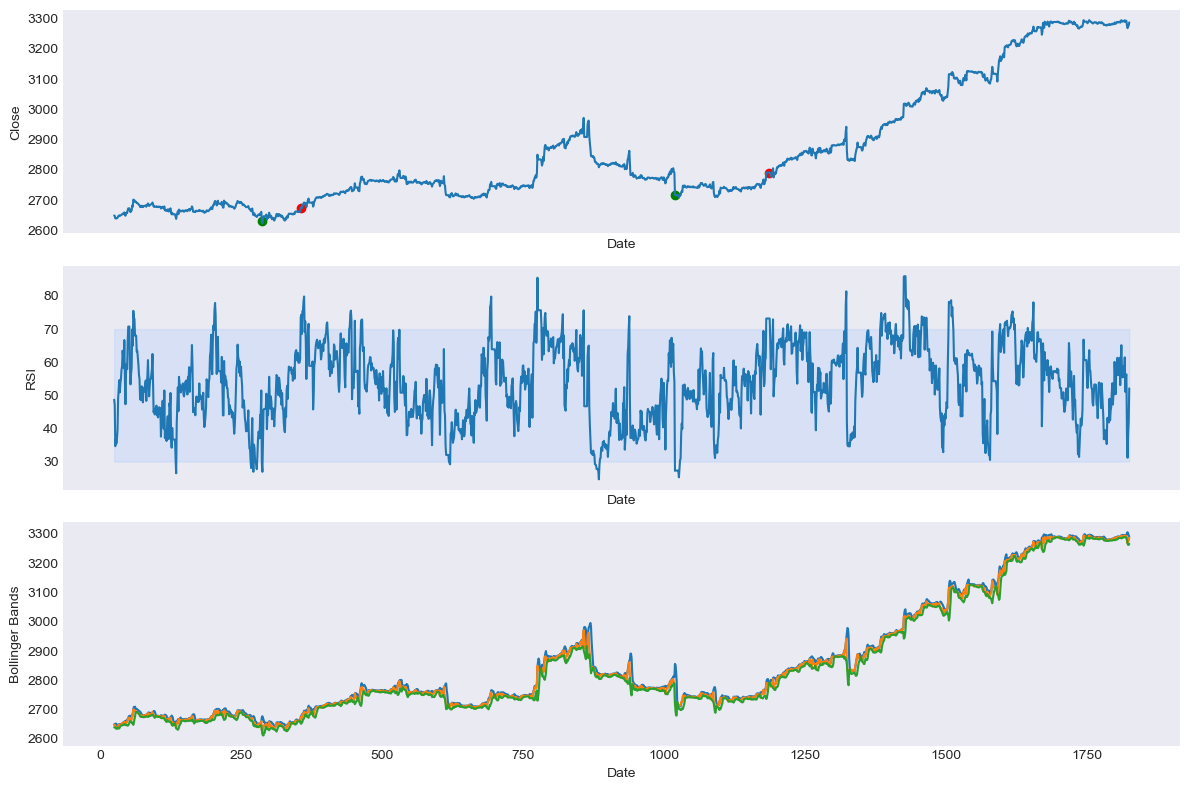

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(index, df['Close'], label='Close')
ax0.set_xlabel('Date')
ax0.set_ylabel('Close')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=df.loc[day, 'Close'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=df.loc[day, 'Close'], color='red')

ax1.plot(index, df['RSI'], label='RSI')
ax1.fill_between(index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(index, df['BB_up'], label='BB_up')
ax2.plot(index, df['Close'], label='Close')
ax2.plot(index, df['BB_low'], label='BB_low')
ax2.fill_between(index, y1=df['BB_low'], y2=df['BB_up'], color='#adccff', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()
#The below, I plot the action with green points (entry points) and red points (exit points) with the Adjusted Close Price of the McDonald (2015 April to 2017 April). Alongside, the RSI indicators and Bollinger Bands are plotted to show how two indicators contribute to a trading action. From the graph, it shows the strategy is good. It captures a couple relative some low prices and high price during the period. One should backtest to get how well the strategy does compared to benchmark.